# 침착맨 클립 재미도 데이터 탐색적 분석 (EDA)
 
- **목표**: dataset.h5에서 로드한 데이터의 패턴을 탐색하여 재미도 분류 모델 학습을 위한 인사이트 도출
 
- **데이터**: Config1 (112차원, 4구간 × 28차원)
- 감정 특징: 20차원 (평균 + 표준편차)  
- 오디오 특징: 4차원 (VAD 필터링)
- VAD 특징: 1차원 (발화 비율)
- 텐션 특징: 3차원 (평균 + 표준편차 + 최대값)

In [35]:
# import os
# import sys
# import warnings
# from pathlib import Path

# # 경고 메시지 무시
# warnings.filterwarnings('ignore')

# # 🎯 프로젝트 루트 찾기 (노트북 기준)
# current_notebook = Path.cwd()  # 노트북이 실행되는 디렉토리
# project_root = current_notebook.parent.parent  # clips_training/notebooks → project_root
# sys.path.insert(0, str(project_root))

# print(f"📁 프로젝트 루트: {project_root}")
# print(f"📁 현재 작업 디렉토리: {current_notebook}")

In [15]:
# import h5py
# import numpy as np

# # 직접 데이터 로드
# with h5py.File('../../dataset/dataset.h5', 'r') as f:
#     current_size = f.attrs['current_size']
#     X = f['features_config_1'][:current_size]
#     y = f['labels'][:current_size]
#     clip_ids = [f['clip_ids'][i].decode('utf-8') for i in range(current_size)]

# print(f"로드 완료: {X.shape}, {len(y)}")

In [ ]:
# 필수 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import h5py


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 환경 설정 완료 (경고 숨김 + 한글 폰트)")

✅ 환경 설정 완료 (경고 숨김 + 한글 폰트)


In [2]:
# import os
# # 더 확실한 한글 설정
# plt.rcParams['font.family'] = ['Malgun Gothic', 'DejaVu Sans']  # 리스트로 설정
# plt.rcParams['font.sans-serif'] = ['Malgun Gothic', 'Arial Unicode MS', 'DejaVu Sans']
# plt.rcParams['axes.unicode_minus'] = False

# # 또는 직접 폰트 경로 설정
# import matplotlib.font_manager as fm
# font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows 기본 경로
# if os.path.exists(font_path):
#     font_prop = fm.FontProperties(fname=font_path)
#     plt.rcParams['font.family'] = font_prop.get_name()

In [3]:
# 📊 직접 HDF5 데이터 로드
print("📊 dataset.h5에서 직접 데이터 로드 중...")

# HDF5 파일 로드
dataset_path = '../../dataset/dataset.h5'
target_config = 1  # config1 = 112차원

with h5py.File(dataset_path, 'r') as f:
    # 기본 정보 확인
    current_size = f.attrs['current_size']
    print(f"   전체 샘플 수: {current_size}")
    
    # 데이터 로드
    X = f[f'features_config_{target_config}'][:current_size]
    y = f['labels'][:current_size] 
    
    # 클립 ID 로드 (문자열 처리)
    clip_ids_raw = f['clip_ids'][:current_size]
    clip_ids = []
    for clip_id in clip_ids_raw:
        if isinstance(clip_id, bytes):
            clip_ids.append(clip_id.decode('utf-8'))
        else:
            clip_ids.append(str(clip_id))
    
    # 메타데이터
    dataset_name = f.attrs.get('dataset_name', 'Unknown')
    created_at = f.attrs.get('created_at', 'Unknown')
    version = f.attrs.get('version', 'Unknown')

print(f"✅ 데이터 로드 완료!")
print(f"   데이터 형태: {X.shape}")
print(f"   라벨 수: {len(y)}")
print(f"   클립 ID 수: {len(clip_ids)}")
print(f"   데이터셋: {dataset_name} (v{version})")

📊 dataset.h5에서 직접 데이터 로드 중...
   전체 샘플 수: 100
✅ 데이터 로드 완료!
   데이터 형태: (100, 112)
   라벨 수: 100
   클립 ID 수: 100
   데이터셋: chimchakman_funny_v1 (v2.0)


In [4]:
# 📋 특징명 생성 (28차원 × 4구간 = 112차원)
def create_feature_names(target_config=1):
    """특징명 생성"""
    # 28차원 기본 특징 정의
    base_features = []
    
    # 감정 특징 (20차원: 평균 10 + 표준편차 10)
    emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 
               'neutral', 'sadness', 'surprise', 'valence', 'arousal']
    for emotion in emotions:
        base_features.append(f'emotion_{emotion}_mean')
    for emotion in emotions:
        base_features.append(f'emotion_{emotion}_std')
    
    # 오디오 특징 (4차원: VAD 필터링)
    base_features.extend([
        'voice_rms_mean',       # 발화 평균 음량
        'voice_rms_max',        # 발화 최대 음량 (핵심!)
        'background_rms_mean',  # 배경음 평균
        'total_rms_std'         # 전체 변동성
    ])
    
    # VAD 특징 (1차원)
    base_features.append('vad_ratio')
    
    # 텐션 특징 (3차원)
    base_features.extend(['tension_mean', 'tension_std', 'tension_max'])
    
    # 구간별 특징명 생성
    segments = 4 if target_config == 1 else (3 if target_config == 2 else 2)
    feature_names = []
    
    for seg in range(1, segments + 1):
        for feat in base_features:
            feature_names.append(f'segment{seg}_{feat}')
    
    return feature_names

# 특징명 생성
feature_names = create_feature_names(target_config)
print(f"📋 특징명 생성 완료: {len(feature_names)}개")

📋 특징명 생성 완료: 112개


In [5]:
# 📊 DataFrame 생성 (분석 편의성)
print("📊 DataFrame 생성 중...")

# 기본 DataFrame 생성
df = pd.DataFrame(X, columns=feature_names)

# 라벨 및 메타데이터 추가
df['label'] = y
df['label_name'] = df['label'].map({0: 'boring', 1: 'funny'})
df['clip_id'] = clip_ids
df['sample_index'] = range(len(df))

print(f"✅ DataFrame 생성 완료: {df.shape}")
print(f"   컬럼 수: {len(df.columns)}")
print(f"   클래스 분포: {df['label_name'].value_counts().to_dict()}")

📊 DataFrame 생성 중...
✅ DataFrame 생성 완료: (100, 116)
   컬럼 수: 116
   클래스 분포: {'funny': 52, 'boring': 48}


In [6]:
# ## 📊 1. 기본 데이터 정보

# 데이터셋 기본 정보
print("📋 데이터셋 기본 정보")
print("=" * 50)
print(f"전체 샘플 수: {len(df)}")
print(f"특징 수: {len(feature_names)}")
print(f"클립 ID 예시: {clip_ids[:5]}")

# 클래스 분포
print(f"\n📊 클래스 분포:")
class_counts = df['label_name'].value_counts()
for label, count in class_counts.items():
    percentage = count / len(df) * 100
    print(f"   {label}: {count}개 ({percentage:.1f}%)")

# 데이터 타입 및 결측값 확인
print(f"\n🔍 데이터 품질:")
print(f"   결측값: {df.isnull().sum().sum()}개")
print(f"   무한값: {np.isinf(df.select_dtypes(include=[np.number]).values).sum()}개")
print(f"   데이터 타입: {df.dtypes.value_counts().to_dict()}")


📋 데이터셋 기본 정보
전체 샘플 수: 100
특징 수: 112
클립 ID 예시: ['f_004_급_유턴_1.0_24.0', 'f_016_밥상머리_교육_0.0_24.0', 'f_020_칭찬맨_몰라_0.0_30.0', 'f_022_시청자_취미_구경하기_2523.0_2558.0', 'f_028_호크아이_슨배임_좀_업그레이드_해줘라_628.0_669.0']

📊 클래스 분포:
   funny: 52개 (52.0%)
   boring: 48개 (48.0%)

🔍 데이터 품질:
   결측값: 0개
   무한값: 0개
   데이터 타입: {dtype('float32'): 112, dtype('O'): 2, dtype('int32'): 1, dtype('int64'): 1}


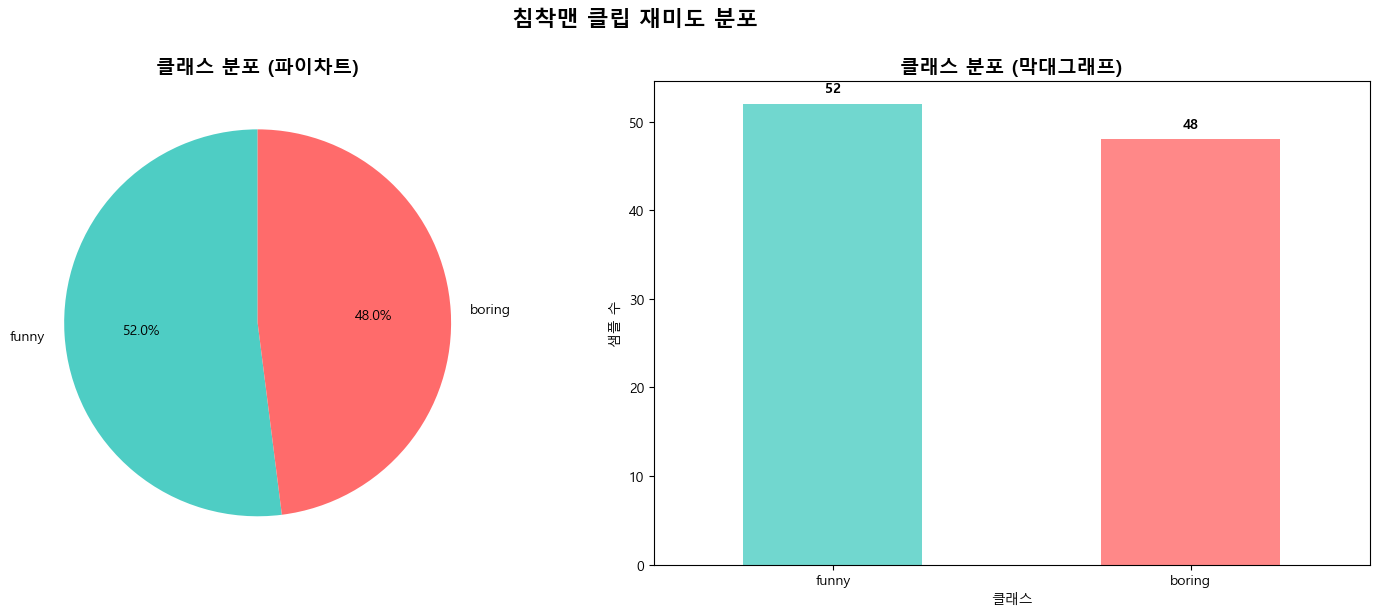

In [8]:

# ## 📈 2. 클래스 분포 시각화
# 클래스 분포 파이차트 + 막대그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 파이차트
colors = ['#4ECDC4', '#FF6B6B']  # boring: 청록, funny: 빨강
class_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
                  colors=colors, startangle=90)
axes[0].set_title('클래스 분포 (파이차트)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# 막대그래프
class_counts.plot(kind='bar', ax=axes[1], color=colors, alpha=0.8)
axes[1].set_title('클래스 분포 (막대그래프)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('클래스')
axes[1].set_ylabel('샘플 수')
axes[1].tick_params(axis='x', rotation=0)

# 막대 위에 숫자 표시
for i, v in enumerate(class_counts.values):
    axes[1].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('침착맨 클립 재미도 분포', fontsize=16, fontweight='bold', y=1.02)
plt.show()

In [9]:
# 🧩 핵심 특징 그룹 정의 (직접 정의)
def get_key_feature_groups():
    """핵심 특징 그룹 반환"""
    key_features = {
        'audio_critical': [
            'voice_rms_max',         # 발화 최대값 (재미 순간!)
            'background_rms_mean',   # 배경음 (웃음+효과음)  
            'total_rms_std'          # 음량 변동성
        ],
        'emotion_critical': [
            'arousal_mean',          # 흥분도 평균
            'happiness_mean',        # 행복 평균
            'anger_mean',            # 화남 평균
            'arousal_std'            # 흥분도 변동성
        ],
        'tension_critical': [
            'tension_max',           # 텐션 피크
            'tension_mean',          # 평균 텐션
            'tension_std'            # 텐션 변동성
        ],
        'vad_critical': [
            'vad_ratio'              # 발화 비율
        ]
    }
    
    # 실제 특징명으로 확장 (모든 구간)
    expanded_features = {}
    for group_name, patterns in key_features.items():
        expanded_features[group_name] = []
        for pattern in patterns:
            # 각 구간별로 특징 찾기
            matching_features = [f for f in feature_names if pattern in f]
            expanded_features[group_name].extend(matching_features)
    
    return expanded_features

def get_feature_groups():
    """전체 특징 그룹 반환 (블록별)"""
    segments = 4  # config1 = 4구간
    block_size = 28  # 구간별 특징 수
    
    feature_groups = {}
    
    # 구간별 블록
    for seg in range(segments):
        seg_start = seg * block_size
        feature_groups[f'segment{seg+1}_emotion'] = feature_names[seg_start:seg_start + 20]
        feature_groups[f'segment{seg+1}_audio'] = feature_names[seg_start + 20:seg_start + 24]
        feature_groups[f'segment{seg+1}_vad'] = feature_names[seg_start + 24:seg_start + 25]
        feature_groups[f'segment{seg+1}_tension'] = feature_names[seg_start + 25:seg_start + 28]
    
    # 전체 블록별 (구간 통합)
    feature_groups['all_emotion'] = []
    feature_groups['all_audio'] = []
    feature_groups['all_vad'] = []
    feature_groups['all_tension'] = []
    
    for seg in range(segments):
        seg_start = seg * block_size
        feature_groups['all_emotion'].extend(feature_names[seg_start:seg_start + 20])
        feature_groups['all_audio'].extend(feature_names[seg_start + 20:seg_start + 24])
        feature_groups['all_vad'].extend(feature_names[seg_start + 24:seg_start + 25])
        feature_groups['all_tension'].extend(feature_names[seg_start + 25:seg_start + 28])
    
    return feature_groups

# 특징 그룹 생성
key_features = get_key_feature_groups()
feature_groups = get_feature_groups()

print("🧩 핵심 특징 그룹:")
print("=" * 50)
for group_name, features in key_features.items():
    print(f"{group_name}: {len(features)}개")
    for feature in features[:3]:  # 처음 3개만 출력
        print(f"   - {feature}")
    if len(features) > 3:
        print(f"   ... 외 {len(features)-3}개")

print(f"\n📊 전체 특징 블록:")
for group_name, features in feature_groups.items():
    if group_name.startswith('all_'):
        print(f"{group_name}: {len(features)}개 특징")


🧩 핵심 특징 그룹:
audio_critical: 12개
   - segment1_voice_rms_max
   - segment2_voice_rms_max
   - segment3_voice_rms_max
   ... 외 9개
emotion_critical: 16개
   - segment1_emotion_arousal_mean
   - segment2_emotion_arousal_mean
   - segment3_emotion_arousal_mean
   ... 외 13개
tension_critical: 12개
   - segment1_tension_max
   - segment2_tension_max
   - segment3_tension_max
   ... 외 9개
vad_critical: 4개
   - segment1_vad_ratio
   - segment2_vad_ratio
   - segment3_vad_ratio
   ... 외 1개

📊 전체 특징 블록:
all_emotion: 80개 특징
all_audio: 16개 특징
all_vad: 4개 특징
all_tension: 12개 특징


🎯 분석할 핵심 특징 수: 44


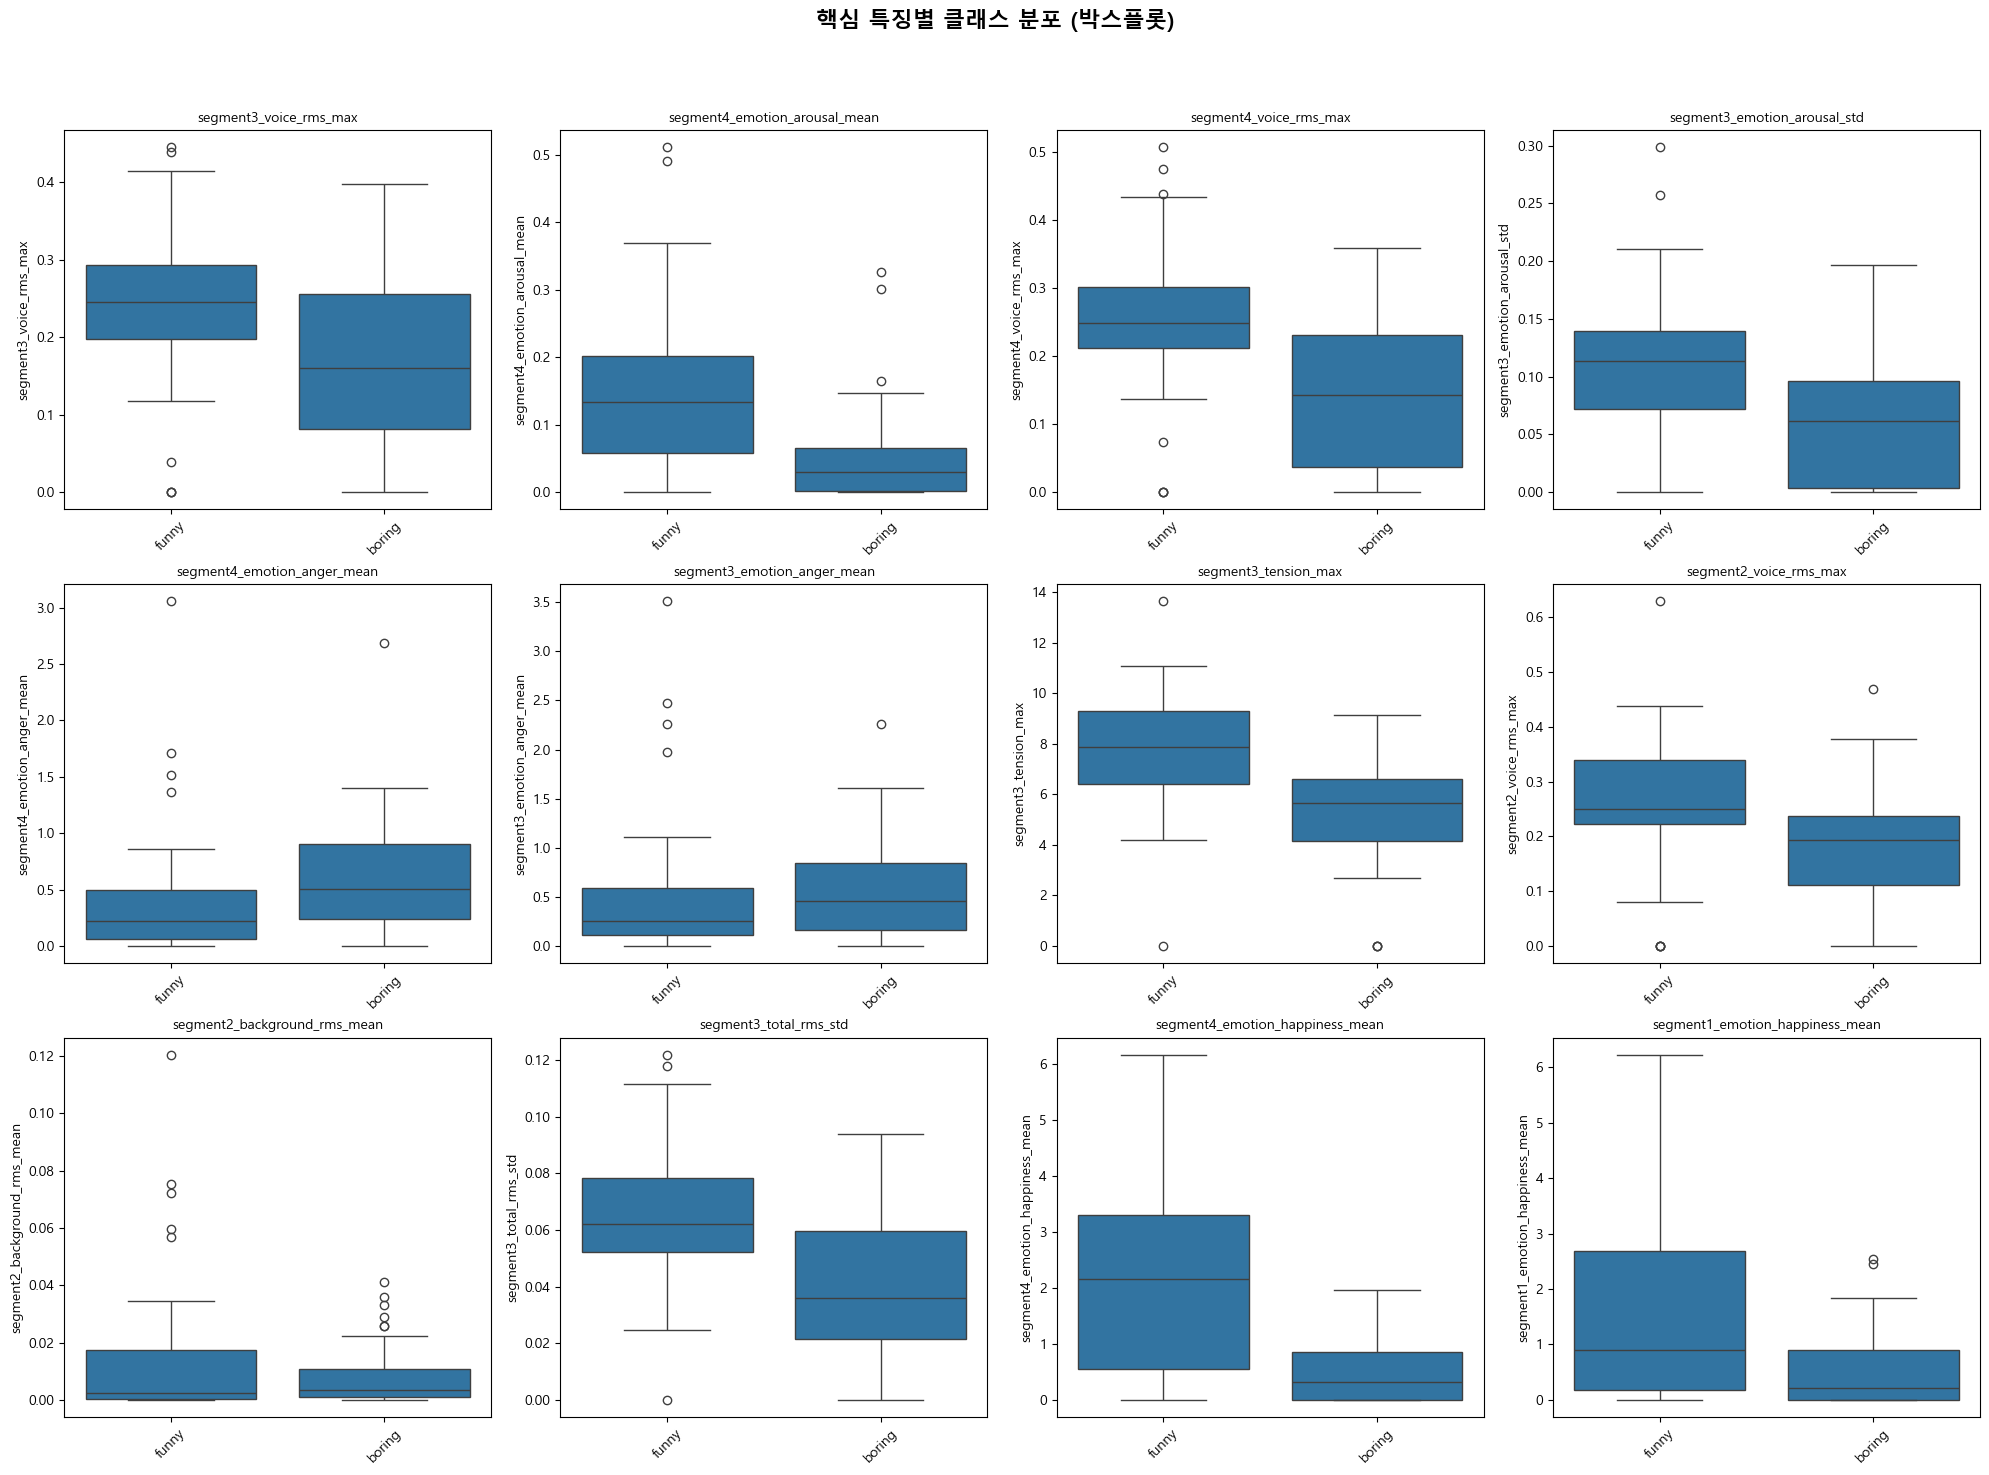

In [12]:
# 📊 4. 핵심 특징별 클래스 분포 비교

# 핵심 특징들의 클래스별 분포 비교 (박스플롯)
key_feature_names = []
for group_features in key_features.values():
    key_feature_names.extend(group_features)

# 중복 제거
key_feature_names = list(set(key_feature_names))
print(f"🎯 분석할 핵심 특징 수: {len(key_feature_names)}")

# 핵심 특징별 박스플롯 (상위 12개만)
n_features_to_plot = min(12, len(key_feature_names))
selected_features = key_feature_names[:n_features_to_plot]

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    if feature in df.columns:
        sns.boxplot(data=df, x='label_name', y=feature, ax=axes[i])
        axes[i].set_title(f'{feature}', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].text(0.5, 0.5, f'{feature}\n(특징 없음)', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('핵심 특징별 클래스 분포 (박스플롯)', fontsize=16, fontweight='bold', y=0.98)
plt.show()


In [13]:
# 핵심 특징들의 클래스 간 차이 통계 검증 (t-test)
statistical_results = []

for feature in selected_features:
    if feature in df.columns:
        boring_data = df[df['label_name'] == 'boring'][feature].dropna()
        funny_data = df[df['label_name'] == 'funny'][feature].dropna()
        
        # t-test 수행
        t_stat, p_value = stats.ttest_ind(boring_data, funny_data)
        
        # 효과 크기 (Cohen's d) 계산
        pooled_std = np.sqrt(((len(boring_data) - 1) * np.var(boring_data, ddof=1) + 
                             (len(funny_data) - 1) * np.var(funny_data, ddof=1)) / 
                            (len(boring_data) + len(funny_data) - 2))
        cohens_d = (np.mean(funny_data) - np.mean(boring_data)) / pooled_std
        
        statistical_results.append({
            'feature': feature,
            'boring_mean': np.mean(boring_data),
            'funny_mean': np.mean(funny_data),
            'mean_diff': np.mean(funny_data) - np.mean(boring_data),
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'significant': p_value < 0.05
        })

# 결과를 DataFrame으로 정리
stats_df = pd.DataFrame(statistical_results)
stats_df = stats_df.sort_values('p_value')

print("📊 클래스 간 차이 통계 검증 결과 (p-value 순)")
print("=" * 80)

# 컬럼 헤더 (백슬래시 문제 해결)
cohens_d_header = "Cohen's d"
print(f"{'특징명':<30} {'Boring평균':<10} {'Funny평균':<10} {'차이':<8} {'p-value':<10} {cohens_d_header:<10} {'유의'}")
print("-" * 80)

for _, row in stats_df.head(10).iterrows():
    significance = "✅" if row['significant'] else "❌"
    print(f"{row['feature']:<30} {row['boring_mean']:<10.3f} {row['funny_mean']:<10.3f} {row['mean_diff']:<8.3f} {row['p_value']:<10.3f} {row['cohens_d']:<10.3f} {significance}")


📊 클래스 간 차이 통계 검증 결과 (p-value 순)
특징명                            Boring평균   Funny평균    차이       p-value    Cohen's d  유의
--------------------------------------------------------------------------------
segment4_emotion_happiness_mean 0.497      2.166      1.670    0.000      1.269      ✅
segment3_tension_max           5.327      7.871      2.543    0.000      1.212      ✅
segment3_total_rms_std         0.039      0.066      0.027    0.000      1.065      ✅
segment4_emotion_arousal_mean  0.051      0.154      0.103    0.000      1.055      ✅
segment4_voice_rms_max         0.147      0.253      0.106    0.000      1.007      ✅
segment3_emotion_arousal_std   0.061      0.113      0.053    0.000      0.955      ✅
segment1_emotion_happiness_mean 0.514      1.517      1.002    0.000      0.768      ✅
segment2_voice_rms_max         0.177      0.263      0.087    0.000      0.752      ✅
segment3_voice_rms_max         0.163      0.242      0.080    0.000      0.723      ✅
segment4_emotion_anger_m

📊 상관관계 분석 특징 수: 19


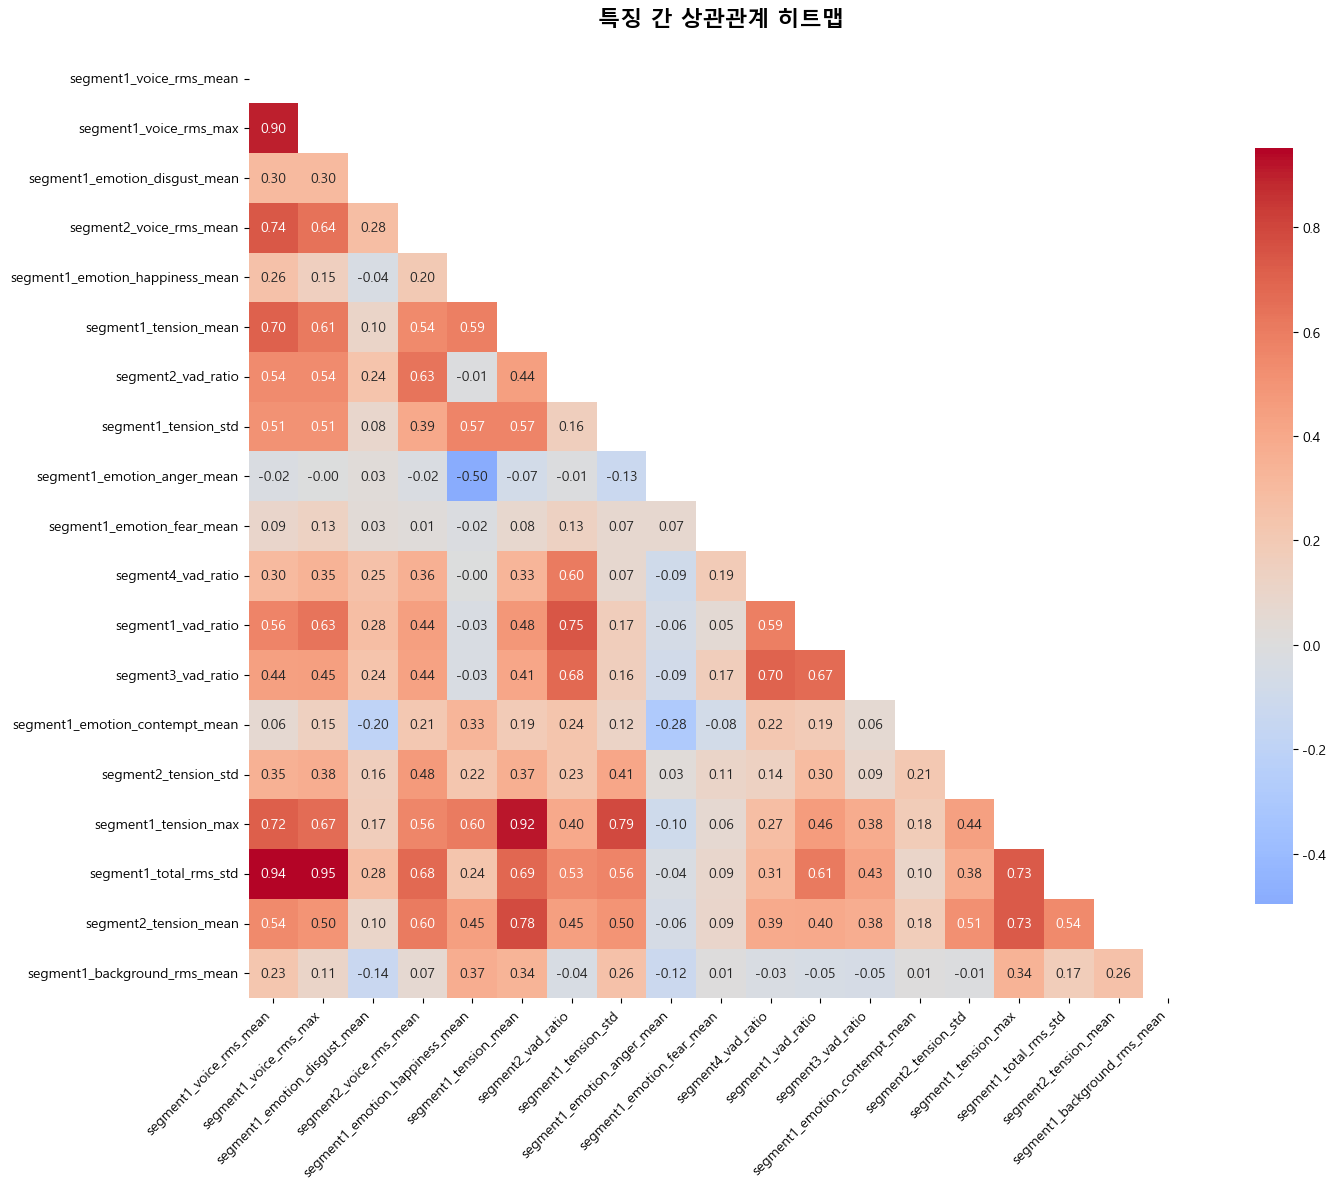


🔥 높은 상관관계 (|r| > 0.7) 특징 쌍:
   segment1_voice_rms_mean ↔ segment1_voice_rms_max: 0.898
   segment1_voice_rms_mean ↔ segment2_voice_rms_mean: 0.739
   segment1_voice_rms_mean ↔ segment1_tension_mean: 0.704
   segment1_voice_rms_mean ↔ segment1_tension_max: 0.717
   segment1_voice_rms_mean ↔ segment1_total_rms_std: 0.941
   segment1_voice_rms_max ↔ segment1_total_rms_std: 0.951
   segment1_tension_mean ↔ segment1_tension_max: 0.915
   segment1_tension_mean ↔ segment2_tension_mean: 0.781
   segment2_vad_ratio ↔ segment1_vad_ratio: 0.747
   segment1_tension_std ↔ segment1_tension_max: 0.790
   segment4_vad_ratio ↔ segment3_vad_ratio: 0.702
   segment1_tension_max ↔ segment1_total_rms_std: 0.731
   segment1_tension_max ↔ segment2_tension_mean: 0.731


In [14]:
# 블록별 상관관계 히트맵
correlation_features = []

# 각 블록에서 대표 특징들만 선택 (너무 많으면 보기 어려우므로)
for group_name, features in feature_groups.items():
    if group_name.startswith('all_'):
        # 각 블록에서 처음 5개 특징만 선택
        selected = [f for f in features[:5] if f in df.columns]
        correlation_features.extend(selected)

# 중복 제거 및 실제 존재하는 특징만 선택
correlation_features = list(set(correlation_features))
correlation_features = [f for f in correlation_features if f in df.columns]

print(f"📊 상관관계 분석 특징 수: {len(correlation_features)}")

if len(correlation_features) > 0:
    # 상관관계 계산
    corr_matrix = df[correlation_features].corr()
    
    # 히트맵 그리기
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각 마스크
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'shrink': 0.8})
    
    plt.title('특징 간 상관관계 히트맵', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 높은 상관관계 (|r| > 0.7) 특징 쌍 찾기
    high_corr_pairs = []
    for i in range(len(correlation_features)):
        for j in range(i+1, len(correlation_features)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append({
                    'feature1': correlation_features[i],
                    'feature2': correlation_features[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        print(f"\n🔥 높은 상관관계 (|r| > 0.7) 특징 쌍:")
        for pair in high_corr_pairs:
            print(f"   {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
    else:
        print(f"\n✅ 높은 상관관계 (|r| > 0.7) 특징 쌍 없음 (다중공선성 위험 낮음)")


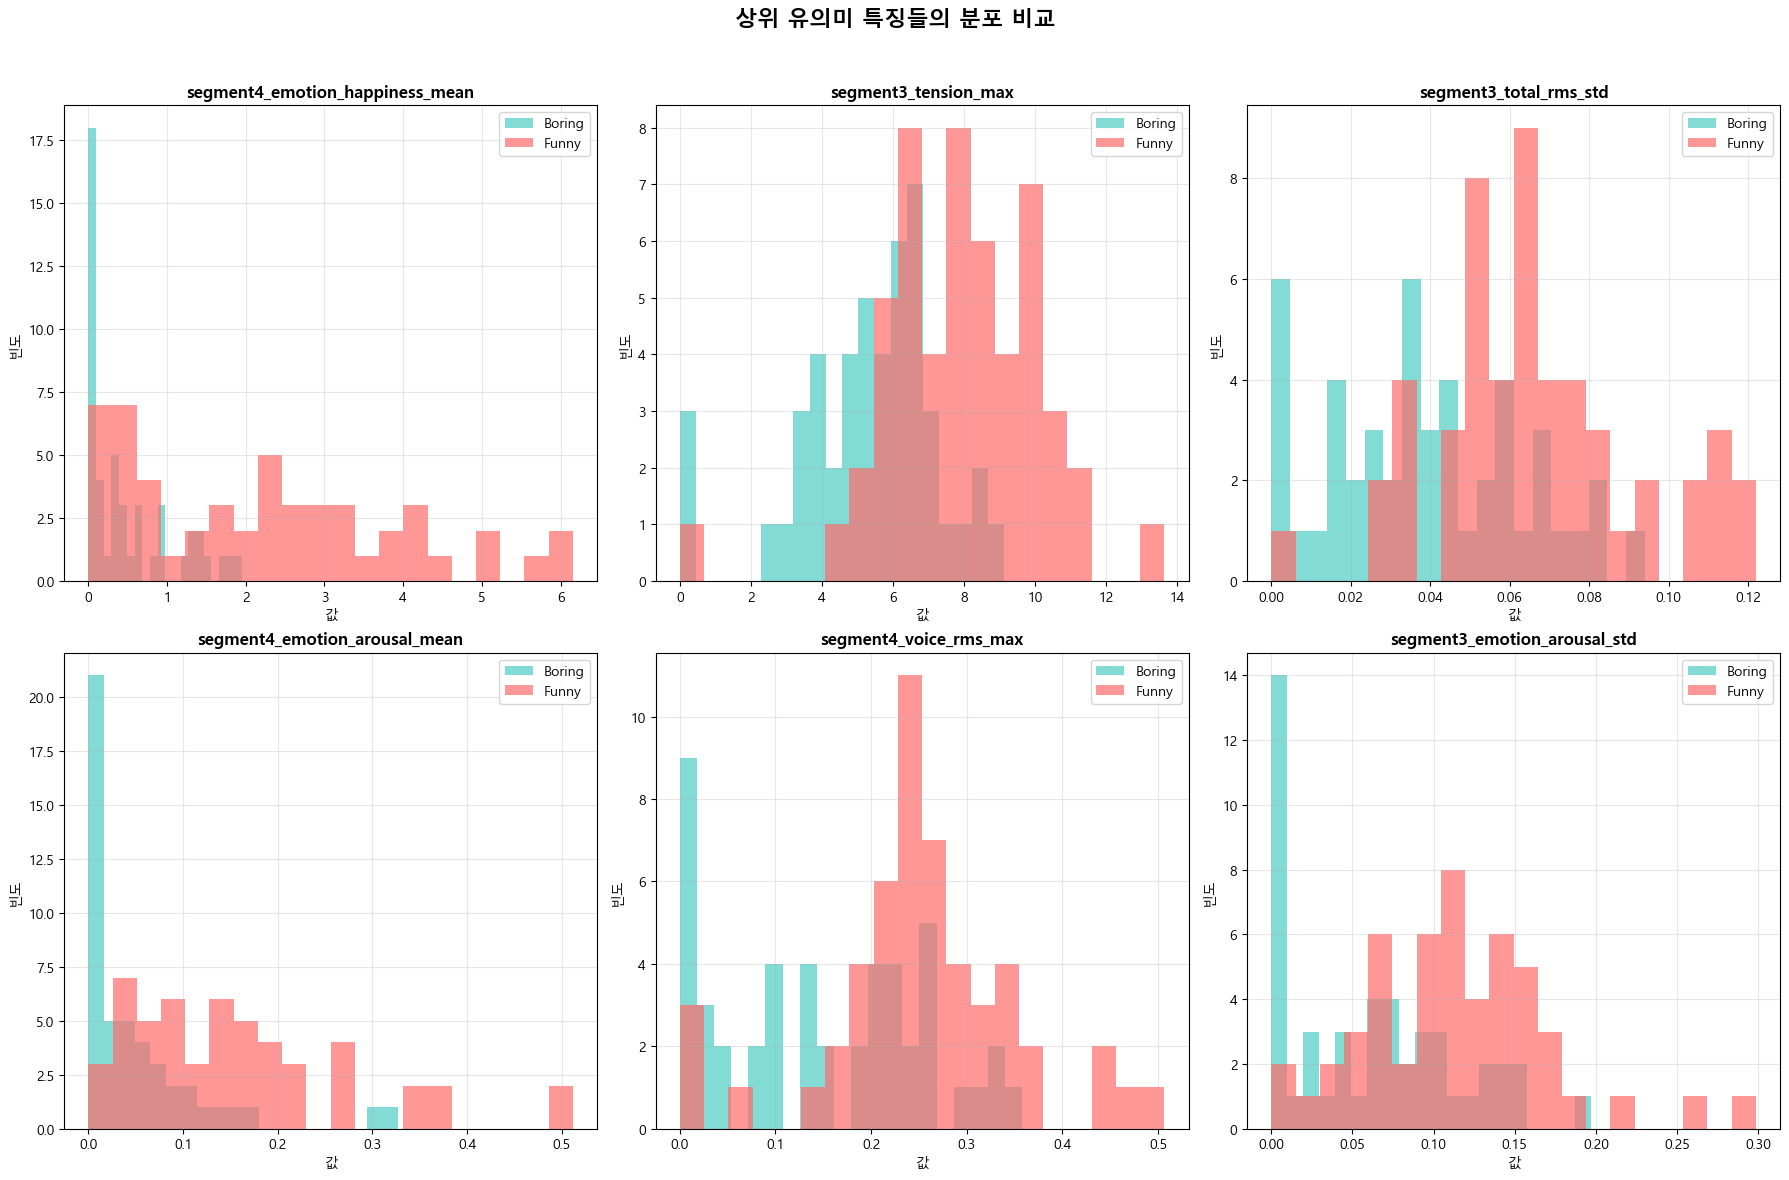

In [15]:
# 가장 유의미한 특징들의 분포 히스토그램
top_significant_features = stats_df.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_significant_features):
    if feature in df.columns:
        # 클래스별 히스토그램
        boring_data = df[df['label_name'] == 'boring'][feature].dropna()
        funny_data = df[df['label_name'] == 'funny'][feature].dropna()
        
        axes[i].hist(boring_data, alpha=0.7, label='Boring', color='#4ECDC4', bins=20)
        axes[i].hist(funny_data, alpha=0.7, label='Funny', color='#FF6B6B', bins=20)
        
        axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('값')
        axes[i].set_ylabel('빈도')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('상위 유의미 특징들의 분포 비교', fontsize=16, fontweight='bold', y=0.98)
plt.show()


In [16]:
# ## 🎯 8. 핵심 인사이트 요약

# %%
print("🎯 EDA 핵심 인사이트 요약")
print("=" * 60)

# 1. 데이터 균형성
funny_ratio = df['label_name'].value_counts()['funny'] / len(df)
balance_status = "균형잡힌" if 0.4 <= funny_ratio <= 0.6 else "불균형"
print(f"1️⃣ 데이터 균형성: {balance_status} (Funny: {funny_ratio:.1%})")

# 2. 유의미한 특징 수
significant_features = stats_df[stats_df['significant'] == True]
print(f"2️⃣ 통계적 유의미한 특징: {len(significant_features)}/{len(stats_df)} ({len(significant_features)/len(stats_df)*100:.1f}%)")

# 3. 가장 차별적인 특징 top 3
if len(significant_features) > 0:
    print(f"3️⃣ 가장 차별적인 특징 Top 3:")
    for i, (_, row) in enumerate(significant_features.head(3).iterrows()):
        direction = "Funny > Boring" if row['mean_diff'] > 0 else "Boring > Funny"
        print(f"   {i+1}. {row['feature']}: p={row['p_value']:.3f}, d={row['cohens_d']:.2f} ({direction})")

# 4. 상관관계 요약
print(f"4️⃣ 다중공선성 위험: {'낮음' if len(high_corr_pairs) == 0 else f'주의 ({len(high_corr_pairs)}개 쌍)'}")

# 5. 데이터 품질
nan_count = df.isnull().sum().sum()
print(f"5️⃣ 데이터 품질: {'좋음' if nan_count == 0 else f'결측값 {nan_count}개 있음'}")

print(f"\n💡 학습 모델 권장사항:")
print(f"   - XGBoost/RandomForest 등 트리 기반 모델 적합")
print(f"   - 특징 선택 필요성: {'낮음' if len(significant_features) > len(stats_df)*0.7 else '높음'}")
print(f"   - 클래스 가중치 조정: {'불필요' if 0.4 <= funny_ratio <= 0.6 else '필요'}")

🎯 EDA 핵심 인사이트 요약
1️⃣ 데이터 균형성: 균형잡힌 (Funny: 52.0%)
2️⃣ 통계적 유의미한 특징: 10/12 (83.3%)
3️⃣ 가장 차별적인 특징 Top 3:
   1. segment4_emotion_happiness_mean: p=0.000, d=1.27 (Funny > Boring)
   2. segment3_tension_max: p=0.000, d=1.21 (Funny > Boring)
   3. segment3_total_rms_std: p=0.000, d=1.07 (Funny > Boring)
4️⃣ 다중공선성 위험: 주의 (13개 쌍)
5️⃣ 데이터 품질: 좋음

💡 학습 모델 권장사항:
   - XGBoost/RandomForest 등 트리 기반 모델 적합
   - 특징 선택 필요성: 낮음
   - 클래스 가중치 조정: 불필요


In [29]:
# 분석 결과를 CSV로 저장
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

# 통계 검증 결과 저장
stats_df.to_csv(results_dir / "eda_statistical_analysis.csv", index=False, encoding='utf-8')

# 상관관계 매트릭스 저장 (있는 경우)
if len(correlation_features) > 0:
    corr_matrix.to_csv(results_dir / "eda_correlation_matrix.csv", encoding='utf-8')

# 데이터셋 요약 정보 저장
summary_info = {
    'total_samples': len(df),
    'n_features': len(feature_names),
    'class_distribution': df['label_name'].value_counts().to_dict(),
    'funny_ratio': funny_ratio,
    'significant_features_count': len(significant_features),
    'data_quality_score': 100 - (nan_count / df.size * 100)
}

import json
with open(results_dir / "eda_summary.json", 'w', encoding='utf-8') as f:
    json.dump(summary_info, f, ensure_ascii=False, indent=2)

print("💾 분석 결과 저장 완료:")
print(f"   - clips_training/results/eda_statistical_analysis.csv")
print(f"   - clips_training/results/eda_correlation_matrix.csv")
print(f"   - clips_training/results/eda_summary.json")

💾 분석 결과 저장 완료:
   - clips_training/results/eda_statistical_analysis.csv
   - clips_training/results/eda_correlation_matrix.csv
   - clips_training/results/eda_summary.json
